# Basic Normalizing Flow Training and Sampling

In [52]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random
using SpecialFunctions
using Distributions
using MLDatasets

import Flux.Optimise: ADAM, update!
Random.seed!(1234)

PyPlot.rc("font", family="serif"); 

In [53]:
# load earth model data
using JLD2, FileIO
@load "../compass_volume.jld2" X
println(size(X, 4))

1


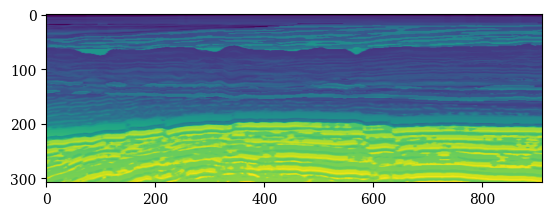

PyObject <matplotlib.image.AxesImage object at 0x17860a680>

In [54]:
X0 = transpose(X[1000, :, :])
fig, ax = subplots(1, 1)
imshow(X0)

    Use dataset from `ffjord`
    
```python
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle


# Dataset iterator
def inf_train_gen(data, rng=None, batch_size=200):
    if rng is None:
        rng = np.random.RandomState()
    
    elif data == "8gaussians":
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]
        dataset = []
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset
    
    if data == "swissroll":
        data = sklearn.datasets.make_swiss_roll(n_samples=batch_size, noise=1.0)[0]
        data = data.astype("float32")[:, [0, 2]]
        data /= 5
        return data

    elif data == "circles":
        data = sklearn.datasets.make_circles(n_samples=batch_size, factor=.5, noise=0.08)[0]
        data = data.astype("float32")
        data *= 3
        return data

    elif data == "rings":
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        # so as not to have the first point = last point, we set endpoint=False
        linspace4 = np.linspace(0, 2 * np.pi, n_samples4, endpoint=False)
        linspace3 = np.linspace(0, 2 * np.pi, n_samples3, endpoint=False)
        linspace2 = np.linspace(0, 2 * np.pi, n_samples2, endpoint=False)
        linspace1 = np.linspace(0, 2 * np.pi, n_samples1, endpoint=False)

        circ4_x = np.cos(linspace4)
        circ4_y = np.sin(linspace4)
        circ3_x = np.cos(linspace4) * 0.75
        circ3_y = np.sin(linspace3) * 0.75
        circ2_x = np.cos(linspace2) * 0.5
        circ2_y = np.sin(linspace2) * 0.5
        circ1_x = np.cos(linspace1) * 0.25
        circ1_y = np.sin(linspace1) * 0.25

        X = np.vstack([
            np.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
            np.hstack([circ4_y, circ3_y, circ2_y, circ1_y])
        ]).T * 3.0
        X = util_shuffle(X, random_state=rng)

        # Add noise
        X = X + rng.normal(scale=0.08, size=X.shape)

        return X.astype("float32")

    elif data == "moons":
        data = sklearn.datasets.make_moons(n_samples=batch_size, noise=0.1)[0]
        data = data.astype("float32")
        data = data * 2 + np.array([-1, -0.2])
        return data

    elif data == "pinwheel":
        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 5
        num_per_class = batch_size // 5
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = rng.randn(num_classes*num_per_class, 2) \
            * np.array([radial_std, tangential_std])
        features[:, 0] += 1.
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))

        return 2 * rng.permutation(np.einsum("ti,tij->tj", features, rotations))

    elif data == "2spirals":
        n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        return x

    elif data == "checkerboard":
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return np.concatenate([x1[:, None], x2[:, None]], 1) * 2

    elif data == "line":
        x = rng.rand(batch_size) * 5 - 2.5
        y = x
        return np.stack((x, y), 1)
    elif data == "cos":
        x = rng.rand(batch_size) * 5 - 2.5
        y = np.sin(x) * 2.5
        return np.stack((x, y), 1)
    else:
        return inf_train_gen("8gaussians", rng, batch_size)
```

In [55]:
function generate_8gaussians(sample_size)
    scale = 4.
    centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / sqrt(2), 1. / sqrt(2)),
               (1. / sqrt(2), -1. / sqrt(2)), (-1. / sqrt(2), 1. / sqrt(2)), (-1. / sqrt(2), -1. / sqrt(2))]
    centers = [(scale * x, scale * y) for (x, y) in centers]
    dataset = []
    for i in 1:sample_size
        point = randn(2) * 0.5
        idx = rand(1:8)
        center = centers[idx]
        point[1] += center[1]
        point[2] += center[2]
        push!(dataset, point)
    end

    dataset = hcat(dataset...)
    dataset = convert(Array{Float32,2}, dataset) / 1.414
end

function generate_pinwheel(batch_size)
    radial_std = 0.3
    tangential_std = 0.1
    num_classes = 5
    num_per_class = batch_size ÷ num_classes
    rate = 0.25
    rads = range(0, stop=2pi, length=num_classes)

    features = randn(num_classes*num_per_class, 2) .* [radial_std tangential_std]
    features[:, 1] .+= 1.0
    labels = repeat(0:num_classes-1, inner=num_per_class)

    angles = rads[labels .+ 1] .+ rate .* exp.(features[:, 1])

    rotated_features = []
    for i in 1:(num_classes * num_per_class)
        a = angles[i]
        rotation_matrix = [cos(a) -sin(a); sin(a) cos(a)]
        push!(rotated_features, rotation_matrix * features[i, :])
    end

    return 2 .* hcat(rotated_features...)
end

generate_pinwheel (generic function with 1 method)

Side notes:

In Julia, the syntax `=:` is used to create a `Symbol`. A `Symbol` in Julia is an immutable datatype that is used primarily to identify something, often as a key in key-value pairs.

In the context of your question, `split=:train` is a way of specifying a key-value pair as an argument to a function. Here, `split` is the key, and `:train` is the value represented as a symbol. This kind of syntax is often used in Julia for functions that accept named arguments or keyword arguments.

In the case of `MNIST(split=:train)`, it's likely that the `MNIST` function accepts a `split` keyword argument to specify which part of the dataset to load. `:train` symbolizes the training portion of the dataset. Similarly, `split=:test` would refer to the test portion of the dataset. This is a common pattern in data loading functions where you need to specify which subset of the data you want to work with.

In [56]:
data_name = "banana"
flow = "tF"
ν = 10

nx          = 1
ny          = 1

#network architecture
n_in        = 2 # put 2d variables into 2 channels
n_hidden    = 16

d = 2   # dimension of data
levels_L    = 1
flowsteps_K = 10

lr = 9f-4
opt = ADAM(lr)

G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;);
#G = G |> gpu 

if data_name == "banana"
    n_train = 60000;
    X_train = sample_banana(n_train);
    
    #training parameters
    batch_size = 50
    maxiter    = cld(n_train, batch_size)
    
elseif data_name == "sin"
    n_train = 60000;
    X1 = rand(Uniform(-5, 5), n_train)
    X2 = sin.(X1)   # sinusoidal data
    # X2 = 50 .* X1 .^ 2   # parabolic data
    X_train = zeros(1, 1, 2, n_train)
    X_train[1, 1, 1, :] = X1
    X_train[1, 1, 2, :] = X2
    
    #training parameters
    batch_size = 50
    maxiter    = cld(n_train, batch_size)
    
elseif data_name == "8gaussians"
    n_train = 1000000
    X_train = zeros(1, 1, 2, n_train)      ##### Use reshape might be easier? #####
    X_train[1, 1, :, :] = generate_8gaussians(n_train)
    
    batch_size = 2000
    maxiter    = 1000
    
elseif data_name == "pinwheel"
    n_train = 1000000
    X_train = generate_pinwheel(n_train)
    X_train = reshape(X_train, (1, 1, 2, n_train))
    
    batch_size = 2000
    maxiter = 1000
    
elseif data_name == "MNIST"
    nx          = 28
    ny          = 28
    n_in        = 1 

    # Alexandereson 2020 setup for MNIST data.
    levels_L    = 2
    flowsteps_K = 10
    
    G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;split_scales=true);
    
    lr = 4e-4
    
    train_data = MNIST(split=:train)[:];
    test_data = MNIST(split=:test)[:];
    X_train, y_train = train_data.features, train_data.targets;
    X_test, y_test = test_data.features, test_data.targets;
    X_train = reshape(X_train, (nx, ny, n_in, size(X_train)[end]));
    X_train = permutedims(X_train, [2, 1, 3, 4]);  # Transpose each image to make images upright
    
    n_train = size(X_train)[end]
    batch_size = 64
    maxiter    = 1000

elseif data_name == "CelebA"
    # Alexandereson 2020 setup for CelebA data. Also glow paper setup.
    levels_L    = 3
    flowsteps_K = 32

elseif data_name == "test"
    d = 1
    n_train = 10000
    X_train = zeros
end

1200

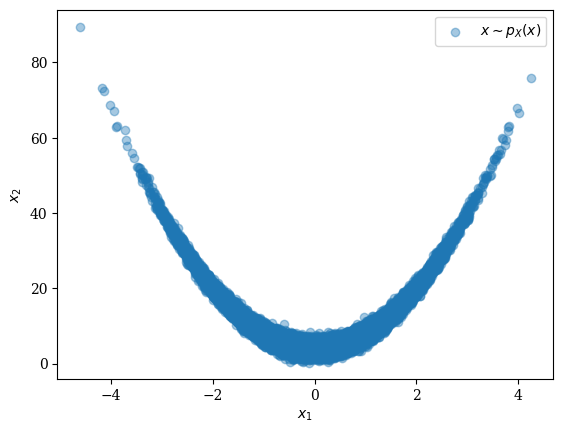

PyObject <matplotlib.legend.Legend object at 0x2bb633460>

In [57]:
if data_name == "MNIST"
    imshow(X_train[:, :, 1, 14])
else
    ## fig = figure(); title(L"x \sim p_x(x)")
    # scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
    scatter(X_train[1,1,1,:], X_train[1,1,2,:]; alpha=0.4, label = L"x \sim p_{X}(x)");
    xlabel(L"x_1"); ylabel(L"x_2");
    # xlim(-4,4); ylim(0,30);
    legend();
end

In [58]:
# function loss(G, X)
#     batch_size = size(X)[end] 
    
#     Z, lgdet = G.forward(X)
    
#     l2_loss = 0.5*norm(Z)^2 / batch_size  #likelihood under Normal Gaussian training 
#     dZ = Z / batch_size                   #gradient under Normal Gaussian training
    
#     G.backward(dZ, Z)  #sets gradients of G wrt output and also logdet terms
    
#     return (l2_loss, lgdet)
# end


function loss(G, X)
    batch_size = size(X)[end]
    
    Z, lgdet = G.forward(X)
    
    function l2_loss(Z)
        if flow == "NF"
            likelihood = -0.5*norm(Z)^2   # for sanity check. Recover normalizing flow result.
        elseif flow == "tF"
            cons = loggamma(0.5*(ν+d)) - loggamma(0.5*ν) - 0.5*d*log(pi*ν)
            likelihood = cons - 0.5*(ν + d) * log(1 + (1/ν) * norm(Z)^2)
        end
        
        return -likelihood / batch_size
    end
    
    # use AD
    θ = Flux.params([Z])
    back = Flux.Zygote.pullback(() -> l2_loss(Z), θ)[2]
    grad = back(1f0)
    logprob_grad = grad[θ[1]]
    
    G.backward(logprob_grad, Z)  # sets gradients of G wrt output and also logdet terms
    
    return (0.01*l2_loss(Z), lgdet, logprob_grad, Z)
end

loss (generic function with 1 method)

In [59]:
eps = 3

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for ep in 1:eps
    for j = 1:maxiter
        Base.flush(Base.stdout)
        # idx = ((j-1)*batch_size+1):(j*batch_size)
        idx = rand(1:n_train, batch_size)

        X = X_train[:,:,:,idx]
        #x = x |> gpu

        losses = loss(G, X) #sets gradients of G

        loss_l2_list[j]    = losses[1]
        loss_lgdet_list[j] = losses[2]

        (j%50==0) && println("Iteration=", j, "/", maxiter,
                "; f l2 = ",   loss_l2_list[j], 
                "; f lgdet = ",loss_lgdet_list[j], 
                "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j])

        for p in get_params(G) 
            update!(opt,p.data,p.grad)
        end
    end
end

Iteration=50/1200; f l2 = 0.006725267717477053; f lgdet = -0.09353950619697571; f nll objective = 0.10026477391445276
Iteration=100/1200; f l2 = 0.009638789164389636; f lgdet = 3.3109142780303955; f nll objective = -3.301275488866006
Iteration=150/1200; f l2 = 0.01423735017327626; f lgdet = 4.916391849517822; f nll objective = -4.902154499344546
Iteration=200/1200; f l2 = 0.013200554998042414; f lgdet = 5.956744194030762; f nll objective = -5.943543639032719
Iteration=250/1200; f l2 = 0.012805185048679175; f lgdet = 6.723752975463867; f nll objective = -6.710947790415188
Iteration=300/1200; f l2 = 0.0139555326323944; f lgdet = 7.268451690673828; f nll objective = -7.254496158041434
Iteration=350/1200; f l2 = 0.016332594082715007; f lgdet = 7.850390434265137; f nll objective = -7.834057840182422
Iteration=400/1200; f l2 = 0.014887761532993721; f lgdet = 8.384478569030762; f nll objective = -8.369590807497769
Iteration=450/1200; f l2 = 0.016471224320049438; f lgdet = 8.882455825805664; f

In [60]:
size(X_train)
squeeze

squeeze (generic function with 1 method)

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with [qq plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

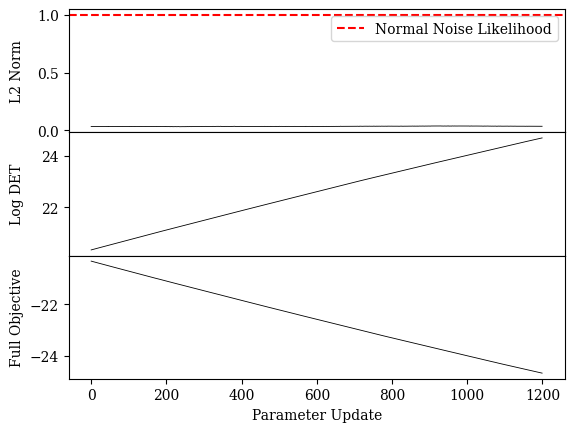

PyObject Text(0.5, 24.0, 'Parameter Update')

In [61]:
if flow == "tF"
    imgname = "flow=$flow" * "_ν=$ν" * "_data=$data_name" * "_batch_size=$batch_size" * "_itr=$maxiter" * "_eps=$eps"
elseif flow == "NF"
    imgname = "flow=$flow" * "_data=$data_name" * "_batch_size=$batch_size" * "_itr=$maxiter" * "_eps=$eps"
end

gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update")

# savename = "training_curves_" * imgname * ".png"
# savefig("07_plots/$savename")

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ in the simple 2D Rosenbrock distribution, we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$.

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

Let's start by taking samples from $z \sim N(0,I) $

t-distribution sampling from paper:

```python
def _sample(self, num_samples):
    d = self._shape[0]
    x = np.random.chisquare(self._nu, num_samples)/self._nu
    x = np.tile(x[:,None], (1,d))
    x = torch.Tensor(x.astype(np.float32))
    z = torch.randn(num_samples, *self._shape)
    return (z/torch.sqrt(x))
```

In [62]:
## sample data from a base distribution

num_test_samples = 500;

if flow == "NF"
    Z_test = randn(Float32, nx, ny, n_in, num_test_samples);
elseif flow == "tF"
    # t_dist = TDist(ν)
    # Z_test = rand(t_dist, nx, ny, n_in, num_test_samples)
    
    # method 2: following Alexanderson 2020 manually make t distribution data
    x = rand(Chisq(ν), nx, ny, n_in, num_test_samples) ./ ν
    Z_test = randn(nx, ny, n_in, num_test_samples) ./ sqrt.(x)
end

println(size(X_train)) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)


In [63]:
x0 = rand(Chisq(ν), nx, ny, n_in, num_test_samples) ./ ν;
size(x0)

(1, 1, 2, 500)

In [64]:
@which repeat

Base

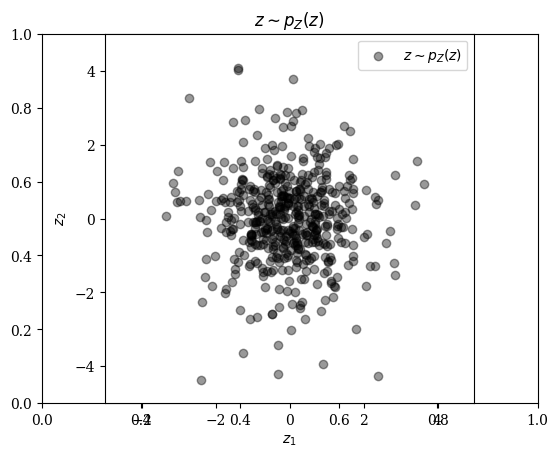

In [65]:
fig = figure(); title(L"z \sim p_{Z}(z)")
ax = fig.add_subplot(111);
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim p_{Z}(z)");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [69]:
size(Z_test)

(1, 1, 2, 500)

In [66]:
X_test = G.inverse(Z_test);

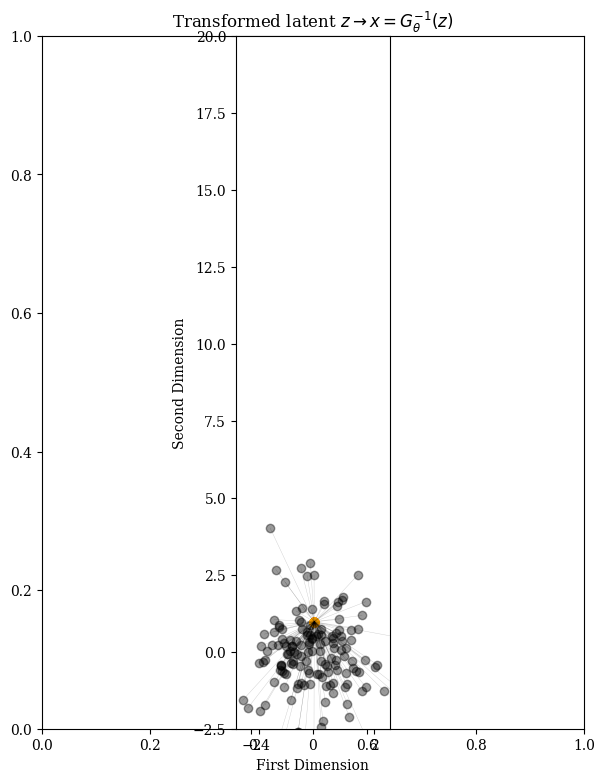

In [67]:
trans_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

fig = figure(figsize=(7,9)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");
ax = fig.add_subplot(111)

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

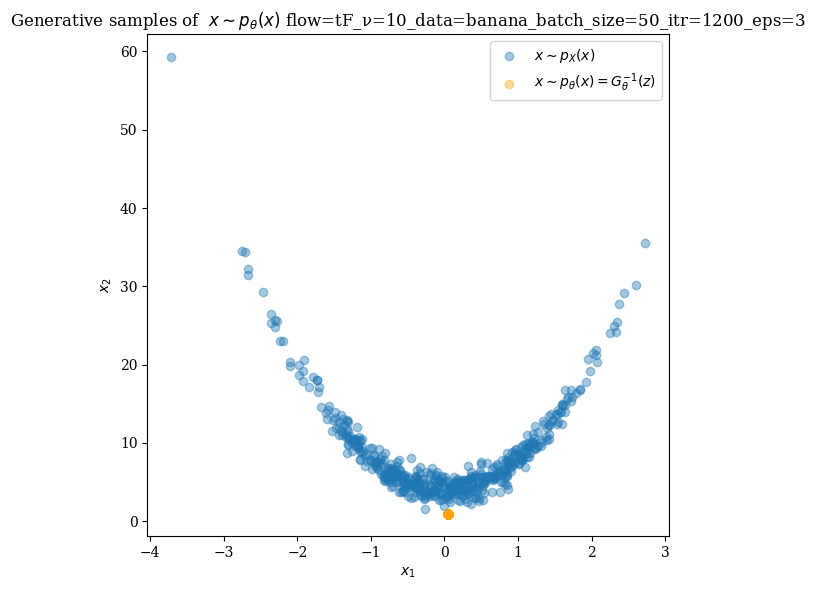

In [68]:
fig, ax = subplots(figsize=(6, 6)); title(L"Generative samples of  $x \sim p_{\theta}(x)$ " * imgname);
# ax = fig.add_subplot(111)
# fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$ " * imgname)
idx = rand(1:n_train, num_test_samples)
scatter(X_train[1,1,1,idx], X_train[1,1,2,idx]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,:], X_test[1,1,2,:]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
# xlim(-0.78,-0.75); ylim(0.79,0.805);
legend();
tight_layout()

# if savefig == true
#     savename = "G-1_samples_" * imgname * ".png"
#     savefig("07_plots/$savename", bbox_inches="tight")
# end

Below are a list of publications in SLIM group that use [InvertibleNetworks.jl](https://github.com/slimgroup/InvertibleNetworks.jl) for seismic/medical imaging, and in general, inverse problems:

[Rafael Orozco, Mathias Louboutin, Felix J. Herrmann. Memory Efficient Invertible Neural Networks for 3D Photoacoustic Imaging. 2022.](https://slim.gatech.edu/Publications/Public/Submitted/2022/orozco2022MIDLmei/midl_2022.html)

[Siahkoohi, Ali, et al. "Wave-equation-based inversion with amortized variational Bayesian inference." arXiv preprint arXiv:2203.15881 (2022).](https://arxiv.org/abs/2203.15881)

[Orozco, Rafael, et al. "Photoacoustic imaging with conditional priors from normalizing flows." NeurIPS 2021 Workshop on Deep Learning and Inverse Problems. 2021.](https://openreview.net/pdf?id=woi1OTvROO1)

[Kumar, Rajiv, et al. "Enabling uncertainty quantification for seismic data preprocessing using normalizing flows (NF)—An interpolation example." First International Meeting for Applied Geoscience & Energy. Society of Exploration Geophysicists, 2021.](https://library.seg.org/doi/abs/10.1190/segam2021-3583705.1)

[Siahkoohi, Ali, and Felix J. Herrmann. "Learning by example: fast reliability-aware seismic imaging with normalizing flows." First International Meeting for Applied Geoscience & Energy. Society of Exploration Geophysicists, 2021.](https://library.seg.org/doi/abs/10.1190/segam2021-3581836.1)